# 实战Kaggle比赛：预测房价

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

使用`pandas`读入并处理数据

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
# 读取数据
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [3]:
# 输出数据shape
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签

In [4]:
# 前四行和列索引为 [0, 1, 2, 3, -3, -2, -1] 的
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
# 输出前四行数据
print(train_data.head())

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub

### 数据预处理
在每个样本中，第一个特征是ID，
我们将其从数据集中删除

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

如上所述，我们有各种各样的数据类型。 在开始建模之前，我们需要对数据进行预处理。 首先，我们将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上， 我们通过将特征重新缩放到零均值和单位方差来标准化数据

In [6]:
# 选取出数值类型的特征列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# apply() 方法应用了一个 lambda 函数，该函数对每一列进行操作，进行标准化处理。（axis=1：对每一行）
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。
我们用独热编码替换它们

In [7]:
# pd.get_dummies() 函数用于将分类变量转换为指示变量（虚拟变量），即进行独热编码。
# 它会将数据框中的每个分类变量扩展为多列，其中每一列代表该变量的一个可能取值，并且在相应的列中使用 1 或 0 表示是否存在该取值。
# dummy_na=True 参数表示在生成虚拟变量时，也会为缺失值创建一个额外的列，用于表示原始数据中是否存在缺失值。
# 注意：该方法独热编码可能引入线性相关性的问题
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features, all_features.shape

(      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
 0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
 1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
 2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
 3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
 4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
 ...          ...          ...       ...          ...          ...        ...   
 1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
 1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
 1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
 1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
 1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   
 
       YearRemodAdd  MasVn

从`pandas`格式中提取NumPy格式，并将其转换为张量表示

In [8]:
all_features = all_features.astype(float)
n_train = train_data.shape[0]
# 通过values属性，我们可以 从pandas格式中提取NumPy格式
# 拆分训练集和测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 获取训练集标签
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

In [9]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，我们更关心相对误差，而不是绝对误差。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时， 假设我们的预测偏差了10万美元， 然而那里一栋典型的房子的价值是12.5万美元， 那么模型可能做得很糟糕。 另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差， （在那里，房价中位数超过400万美元） 这可能是一个不错的预测。

解决这个问题的一种方法是用价格预测的对数来衡量差异。 事实上，这也是比赛中官方用来评价提交质量的误差指标。

我们更关心相对误差$\frac{y - \hat{y}}{y}$，
解决这个问题的一种方法是用价格预测的对数来衡量差异

In [10]:
def log_rmse(net, features, labels):
    # 由于我们的对数变换将使得0和负值变为NaN，这里使用torch.clamp将预测值限制在1和∞之间（小于1的都置为1）。
    # 也可以平移变换：如果最小值小于0，则(+1-min())，平移到（1，+∞）；如果大于0小于1，则+1；如果大于1，则不变。
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [17]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, i):
        return (self.features[i], self.labels[i])
    
    def __len__(self):
        return len(self.features)
net = nn.Sequential(nn.Linear(in_features,32), nn.ReLU(), nn.Linear(32,1))
batch_size = 64
train_data = dataset(train_features, train_labels)
test_data = dataset(test_features, torch.zeros_like(test_features))
train_iter = DataLoader(train_data, batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.1)
loss_train = []
loss_test = []
for epoch in range(100):
    for X, y in train_iter:
        optimizer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        optimizer.step()
    loss_train.append(log_rmse(net, train_features, train_labels))
print(loss_train)

with torch.no_grad():
    print(log_rmse(net, X, y))
        

[8.09045696258545, 6.624060153961182, 5.671014785766602, 4.948343276977539, 4.378124237060547, 3.921051025390625, 3.5471088886260986, 3.2332332134246826, 2.962667942047119, 2.7282392978668213, 2.5189051628112793, 2.3319528102874756, 2.1636760234832764, 2.008870840072632, 1.8697973489761353, 1.7401797771453857, 1.6200015544891357, 1.508415699005127, 1.405055284500122, 1.308779239654541, 1.2192927598953247, 1.1351457834243774, 1.055884838104248, 0.981779932975769, 0.9118638634681702, 0.8470727205276489, 0.7857196927070618, 0.7287417054176331, 0.6748973727226257, 0.6248353123664856, 0.5783518552780151, 0.5339431762695312, 0.4935664236545563, 0.4561474919319153, 0.4217967092990875, 0.38950473070144653, 0.3602955937385559, 0.3340287506580353, 0.31042808294296265, 0.2891891300678253, 0.2705109119415283, 0.25383853912353516, 0.23989208042621613, 0.2277452051639557, 0.21736198663711548, 0.2091239094734192, 0.2017529308795929, 0.1962975412607193, 0.19161206483840942, 0.18775510787963867, 0.1849

我们的训练函数将借助Adam优化器

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            # print(l.mean().item())
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

本书在讨论模型选择的部分（ 4.4节） 中介绍了K折交叉验证， 它有助于模型选择和超参数调整。 我们首先需要定义一个函数，在K
折交叉验证过程中返回第i
折的数据。 具体地说，它选择第i
个切片作为验证数据，其余部分作为训练数据。 注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # fold_size表示每份的大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice(start, stop, step)
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

折1，训练log rmse0.169753, 验证log rmse0.156923
折2，训练log rmse0.162177, 验证log rmse0.189386
折3，训练log rmse0.164013, 验证log rmse0.168358
折4，训练log rmse0.168091, 验证log rmse0.154978
折5，训练log rmse0.162560, 验证log rmse0.182750
5-折验证: 平均训练log rmse: 0.165319, 平均验证log rmse: 0.170479


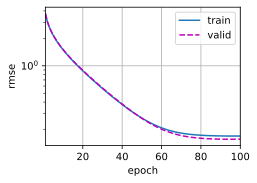

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交Kaggle预测

训练log rmse：0.162505


TypeError: 'dataset' object does not support item assignment

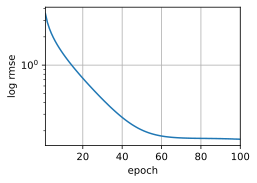

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)